# **2021 Fall AI701 Homework assignment 3**
Read the following problem sheet and submit your completed $\texttt{ipynb}$ file.

## Problem 1 (70 pts)

We will going to implement the sequential importance sampling (SIS) and sequential importance resampling (SIR) for a simple state-space model. The state-space model is defined as follows:

$\displaystyle x_1 \sim \mathcal{N}\bigg(\mu, \frac{\sigma^2}{1 - \rho^2}\bigg).$

$\displaystyle x_t|x_{t-1} \sim \mathcal{N}(\mu + \rho(x_{t-1} - \mu), \sigma^2).$

$\displaystyle y_t|x_t \sim \mathcal{N}(0, e^{x_t}).$

The following codes define the functions required for generating sequences from this model.

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.special import logsumexp

In [2]:
# parameters, we will use a fixed set of parameters throughout this homework.
params = {'mu':-1.0, 'rho':0.95, 'sigma':0.2}

In [3]:
# sample x_1 ~ p(x_1).
def sample_x1(num_samples=1):
    std = params['sigma'] / np.sqrt(1 - params['rho']**2)    
    return params['mu'] + std*npr.normal(size=num_samples)
        
# sample x_t ~ p(x_t|x_{t-1}) with x_prev denoting x_{t-1}.
def sample_x(x_prev):
    mean = params['mu'] + params['rho']*(x_prev - params['mu'])
    shape = None if type(x_prev)==float else x_prev.shape
    return mean + params['sigma']*npr.normal(size=shape)

# sample y_t ~ p(y_t|x_t).
def sample_y(x):    
    shape = None if type(x)==float else x.shape
    return np.exp(0.5*x)*npr.normal(size=shape)

Using these functions, the following code actually generates a sequence $\{y_t\}_{t=1}^T$.

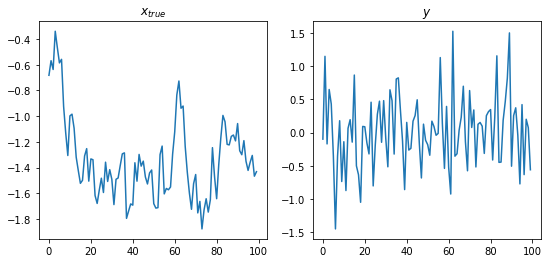

In [4]:
T = 100
x_true = np.zeros(T)
y = np.zeros(T)
npr.seed(42)

x_true[0] = sample_x1()
y[0] = sample_y(x_true[0])
for t in range(1, T):
    x_true[t] = sample_x(x_true[t-1])
    y[t] = sample_y(x_true[t])

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
axes[0].set_title(r'$x_{true}$')
axes[0].plot(range(T), x_true)
axes[1].set_title(r'$y$')
axes[1].plot(range(T), y)

To define sequential importance sampling algorithm, we choose the simplest possible proposal distribution; the prior transition distribution.
$
q(x_t | x_{1:t-1}, y_{1:t}) = p(x_t | x_{t-1}).
$

In [5]:
# propose a sample x_t ~ q(x_t|x_{1:t-1}, y_{1:t}) = p(x_t|x_{t-1})
def propose_x(x_prev):
    return sample_x(x_prev)

# computes the log-likelihood p(y_t|x_t)
def log_likel(y, x):
    var = np.exp(x)
    ll = -0.5*y**2/var - 0.5*np.log(2*np.pi*var)
    return ll

Now we are ready to write the sequential importance sampling algorithm. Let's first start by writing the function to initialize set of particles at $t=1$.

In [6]:
# initialize num_particles number of particles.
# particles are represented with a dictionary:
# 'x' denotes the actual samples of the states with shape (num_particles) * (num_timesteps).
# 'log_w' denotes log of unnormalized importance weights with shape (num_particles) * (num_timesteps).
# After initialization, particles['x'] and particles['log_w'] should have shape (num_particles) * 1.
def init_particles(y, num_particles):
    x = sample_x1(num_samples=num_particles)
    log_w = log_likel(y, x)
    particles = {'num_particles':num_particles, 
                 'x':x[:,None], 
                 'log_w':log_w[:,None]}
    return particles

(a) (20pts) Complete the following code to extend the set of particles for a new observation $y_t$. Taking the set of particles constructed up to time $t-1$ and $y_t$, the function should output update particles with states and unnomarlized importance weights constructed up to time $t$.

In [7]:
# particles['x'] and particles['log_w'] have shape (num_particles) * (t-1)
# given y_t, the following function should return the update set of particles
# where both particles['x'] and particles['log_w'] have shape (num_particles) * t
def SIS_extend_particles(y, particles):
    # complete this part
    ######################################################################
    # Propose a sample x_t ~ q(x_t|x_{1:t-1}, y_{1:t}) = p(x_t|x_{t-1})
    x_t = propose_x(particles['x'][:, -1, np.newaxis])
    # Compute the log of unnormalized importance weights -> log_w_t = log_w_{t-1} + log (p(y_t|x_t))
    log_w_t = particles['log_w'][:, -1, np.newaxis] + log_likel(y, x_t)
    # Concatenate the most recently drawn particles into 'particles' data type
    particles['x'] = np.concatenate((particles['x'], x_t), axis=1)
    particles['log_w'] = np.concatenate((particles['log_w'], log_w_t), axis=1)
    ######################################################################
    return particles

# Once you have the function to extend particles, the SIS algorithm is straightforward as follows.
def run_SIS(y, num_particles):
    particles = init_particles(y[0], num_particles)
    for t in range(1, len(y)):
        particles = SIS_extend_particles(y[t], particles)
    return particles

(b) (10pts) Complete the following functions computing the estimate of the log marginal $\log p(y_{1:T})$ and the effective sample size using the particles constructed up to time $T$. 

Hint: use $\texttt{logsumexp}$ function for numerical stability.

In [8]:
# return a scalar value computing the estimate of the log marginal likelihood log p(y_{1:T})
def SIS_log_marginal(particles):
    # complete this part
    ######################################################################
    # log p(y_{1:T}) = log(\frac{1}{n} \sum_{i=1}^n w_T^{(i)}) = logsumexp(particles['log_w'][:, -1]) - log(n)
    log_p_y = logsumexp(particles['log_w'][:, -1]) - np.log(particles['log_w'].shape[0])
    return log_p_y
    ######################################################################

# return a scalar value computing the effective sample size 
def compute_ess(particles):
    # complete this part
    ######################################################################
    # Normalize the log_w at the final timestep T
    hat_log_w = particles['log_w'][:, -1, np.newaxis] - logsumexp(particles['log_w'][:, -1])
    # n_eff (@ time T) = \frac{1}{\sum_{i=1}^n (\hat{w}_T^{(i)})^2}
    n_eff = 1 / np.exp(logsumexp(2 * hat_log_w))
    return n_eff
    ######################################################################

(c) (10pts) Since we have the true states $x_{\text{true}}$ that we have used for the data generation, we can compute the estimation error for the estimatated states. That is, computing the expected error defined as

$
\displaystyle \mathcal{E}(x_\text{true}) = \frac{1}{T} \mathbb{E}_{p(x_{1:T}|y_{1:T})}\bigg[ \sum_{t=1}^T (x_t - x_{\text{true}, t})^2\bigg] = \frac{1}{T} \int \sum_{t=1}^T (x_t - x_{\text{true}, t})^2 p(x_{1:T}|y_{1:T}) \mathrm{d} x_{1:T}.
$

Complete the following code computing the approximation of this expected error using the particles and importance weights we construct with SIS. Then run the complete codes to get the results.

In [19]:
# return a scalar estimate of the expected error
def estimate_error(x_true, particles):
    # complete this part
    ######################################################################
    # Obtain the size of particles -> T
    T_size = x_true.size
    hat_w = np.exp(particles['log_w'][:, -1] - logsumexp(particles['log_w'][:, -1]))
    estim_err = 0
    for i in range(particles['x'].shape[0]):
        estim_err += hat_w[i] * np.sum(np.square(particles['x'][i] - x_true))
    estim_err = estim_err / T_size
    return estim_err
    ######################################################################

num_particles = 200
particles = run_SIS(y, num_particles)

# TO BE DELETED
# print(np.exp(particles['log_w'][:, -1]).shape)
# print(np.exp(-logsumexp(particles['log_w'][:, -1])))
# hat_w = np.exp(particles['log_w'][:, -1] - logsumexp(particles['log_w'][:, -1]))
# print(hat_w)
# print(particles['x'])
# print(hat_w.shape)
# print(hat_w.sum())
# print(np.matmul(hat_w, particles['x']))
# TO BE DELETED

lm = SIS_log_marginal(particles)
ess = compute_ess(particles)
err = estimate_error(x_true, particles)
print(f'SIS log marginal {lm:.4f}, ESS {ess:.4f}, expected error {err:.4f}')

(200,)
2.556069292826168e+32
[4.01764736e-13 8.88076080e-23 4.62754671e-04 3.60493555e-09
 1.26071115e-09 1.45826756e-08 4.17857075e-05 3.92491591e-07
 8.28805007e-05 1.33330641e-06 2.03120625e-04 4.40607288e-13
 1.76476414e-11 7.10897502e-06 2.92482853e-08 2.13532340e-06
 1.16034400e-06 6.74416557e-09 2.67890331e-03 1.09684138e-04
 9.45837548e-05 4.98098821e-06 5.11199300e-05 9.75351918e-05
 1.04568866e-05 9.29301040e-08 4.12629134e-08 2.47841996e-03
 4.14811750e-07 4.10733066e-07 1.87019814e-05 1.22089837e-06
 2.68707015e-08 9.87305769e-08 3.64092046e-10 3.86721848e-07
 7.09489928e-03 1.46094464e-07 3.47964745e-06 6.02669207e-11
 1.12382866e-05 1.65427795e-09 5.57594766e-09 4.69255942e-04
 7.02956796e-10 7.79016986e-02 2.35739823e-08 2.44496195e-09
 2.94367198e-07 7.51179057e-10 6.35350562e-10 5.28155492e-04
 2.48338056e-06 6.73741438e-05 9.83178913e-06 2.99907241e-04
 1.56695847e-07 1.85841262e-06 1.03110171e-11 5.21576752e-08
 2.56428142e-04 8.85209749e-09 3.31449333e-08 8.97839073

(d) (5pts) For visualization, we will compute the mean and variances of the estimated states.

$
\displaystyle 
\mathbb{E}_{p(x_{1:T}|y_{1:T})}[x_t] = \int x_t p(x_{1:T}|y_{1:T}) \mathrm{d}x_{1:T}, \quad
\mathrm{Var}_{p(x_{1:T}|y_{1:T})}[x_t] = \int (x_t - \mathbb{E}_{p(x_{1:T}|y_{1:T})})^2 p(x_{1:T}|y_{1:T}) \mathrm{d}x_{1:T}.
$

Complete the following codes computing the approximation of expected means and variances using the particles and importance weights we get from SIS. Run the visualization code to see if the algorithm works well.

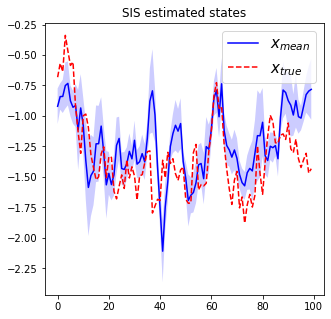

In [21]:
# return a pair of T-dim vectors estimating the mean and variance of the sequence x_{1:T}
def estimate_x_mean_and_var(particles):
    # complete this part
    ######################################################################
    # Calculate \hat{w}_T(x_{1:T}^{(i)})
    hat_w = np.exp(particles['log_w'][:, -1] - logsumexp(particles['log_w'][:, -1]))
    # Calculate Mean x_mean = \sum_{i=1}^n \hat{w}_T (x_{1:T}^{(i)}) x_{1:T}^{(i)}
    x_mean = np.matmul(hat_w, particles['x'])
    # Calculate Variance x_var = \sum_{i=1}^n \hat{w}_T (x_{1:T}^{(i)} - x_mean)^2
    x_var = np.matmul(hat_w, np.square(particles['x'] - x_mean))
    ######################################################################
    return x_mean, x_var

plt.figure(figsize=(5,5))
plt.title('SIS estimated states')
x_mean, x_var = estimate_x_mean_and_var(particles)
x_std = np.sqrt(x_var)
plt.fill_between(range(T), x_mean-x_std, x_mean+x_std, 
                 facecolor='b', edgecolor=None, alpha=0.2)
plt.plot(range(T), x_mean, color='b', label=r'$x_{mean}$')
plt.plot(range(T), x_true, '--r', label=r'$x_{true}$', )
plt.legend(fontsize=15)

(e) (25pts) Complete the following functions required for sequential importance resampling. You may use $\texttt{npr.choice}$ function for categorical resampling step. Run the algorithm to verify your implementation.

In [ ]:
# particles['x'] and particles['log_w'] have shape (num_particles) * (t-1)
# given y_t, the following function should return the update set of particles
# where both particles['x'] and particles['log_w'] have shape (num_particles) * t
def SIR_extend_particles(y, particles):
    # complete this part
    ######################################################################
    # Calculate importance weights hat_w_t at time-step t-1
    hat_w_latest = np.exp(particles['log_w'][:, -1] - logsumexp(particles['log_w'][:, -1]))
    n = particles['num_particles']
    # Draw ancestor indices a_t at time-step t-1
    a_t = npr.choice(n, n, p = hat_w_latest)
    # List up particles['x'] that's going to be proposed based on the ancestor indices a_t
    chosen_particles = particles['x'][a_t, :]
    # Slice elements from chosen_particles at the latest time step t-1
    x_prev_a_t = chosen_particles[:, -1, np.newaxis]
    # Propose a sample x_t ~ q(x_t|x_{1:t-1}^{a_{t-1}^(i)}, y_{1:t}) = p(x_t|x_{t-1}^{a_{t-1}^(i)})
    x_t = propose_x(x_prev_a_t)
    # Compute the log of unnormalized importance weights -> log_w_t = log (p(y_t|x_t^(i)))
    log_w_t = log_likel(y, x_t)
    # Concatenate the most recently drawn particles into 'particles' data type
    particles['x'] = np.concatenate((chosen_particles, x_t), axis=1)
    particles['log_w'] = np.concatenate((particles['log_w'], log_w_t), axis=1)
    ######################################################################
    return particles

def run_SIR(y, num_particles):
    particles = init_particles(y[0], num_particles)
    for t in range(1, len(y)):
        particles = SIR_extend_particles(y[t], particles)
    return particles

# return a scalar value computing the estimate of the log marginal likelihood log p(y_{1:T})
def SIR_log_marginal(particles):
    # complete this part
    ######################################################################
    # log p(y_{1:T}) = \log(\prod_{t=1}^T \frac{1}{n} \sum_{i=1}^n w_t^{(i)})
    log_p_y = 0
    for i in range(particles['log_w'].shape[1]):
        log_p_y += logsumexp(particles['log_w'][:, i]) - np.log(particles['log_w'].shape[0]) 
    return log_p_y
    ######################################################################

num_particles = 200
particles = run_SIR(y, num_particles)

lm = SIR_log_marginal(particles)
ess = compute_ess(particles)
err = estimate_error(x_true, particles)
print(f'SIR log marginal {lm:.4f}, ESS {ess:.4f}, expected error {err:.4f}')

plt.figure(figsize=(5,5))
plt.title('SIR estimated states')
x_mean, x_var = estimate_x_mean_and_var(particles)
x_std = np.sqrt(x_var)
plt.fill_between(range(T), x_mean-x_std, x_mean+x_std, 
                 facecolor='b', edgecolor=None, alpha=0.2)
plt.plot(range(T), x_mean, color='b', label=r'$x_{mean}$')
plt.plot(range(T), x_true, '--r', label=r'$x_{true}$', )
plt.legend(fontsize=15)

## Problem 2 (30pts)
Consider sampling from the following target distribution,

$$
p(x) \propto \exp( - U(x)), \quad U(x) = \frac{1}{2} x^\top A x, \quad A = \begin{bmatrix} 2 & 1.2 \\ 1.2 & 2 \end{bmatrix}, 
$$

where $x \in \mathbb{R}^2$ and $A \in \mathbb{R}^{2\times 2}$. We can visualize the contour plot of the density function as follows:


In [ ]:
A = np.array([[2, 1.2], [1.2, 2]])
# x: 2 dimensional vector or N times 2 dimensional matrix.
def energy_function(x):    
    if x.ndim == 1:
        return 0.5 * np.inner(x, np.dot(A, x)) 
    elif x.ndim == 2:
        return 0.5 * (x * np.dot(x, A)).sum(-1)
    else:
        raise NotImplementedError

def plot_density(alpha=1.0):
    nx, ny = 50, 50
    x = np.linspace(-3, 3, nx)
    y = np.linspace(-3, 3, ny)
    xx, yy = np.meshgrid(x, y)
    z = np.exp(-energy_function(np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], -1)))
    plt.contour(x, y, z.reshape((nx, ny)), cmap='inferno', alpha=alpha)

plot_density()

We will sample from this target distribution using Hamiltonian Monte Carlo. The kinetic energy function and Hamiltonian function are assumed to be

$
K(p) = \frac{1}{2}p^\top p, \quad H(x, p) = U(x) + K(p).
$

Complete the following codes running HMC.

In [ ]:
# computes grad_x U(x) for 2 dimensional vector x.
def energy_function_grad(x):
    # complete this part
    ######################################################################
    
    ######################################################################

# compute the kinetic energy for 2 dimensional momentum vector p.
def kinetic_energy_function(p):
    return 0.5 * np.inner(p, p)

# run HMC and collect (num_samples) number of samples.
# x0: initial position, 2 dimensional vector.
# eps: step size
# L: number of leapfrog integrations
# output: (num_samples) * 2 dimensional matrix collecting the samples.
def run_HMC(x0, eps, L, num_samples):
    # complete this part
    ######################################################################
   
    ######################################################################

Run the following code the verify your sampler.

In [ ]:
x0 = npr.rand(2)
eps = 0.01
L = 30
num_samples = 5000
samples = run_HMC(x0, eps, L, num_samples)
plot_density()
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=20, color='k')